In [2]:
!pip install --upgrade pip && \
pip install pandas && \
pip install seaborn && \
pip install scikit-learn && \
pip install sktime && \
pip install plotly && \
pip install pyarrow && \
pip install fastparquet && \
pip install pmdarima

  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
     ---------------------------------------- 7.2/7.2 MB 19.2 MB/s eta 0:00:00
     ---------------------------------------- 98.0/98.0 KB ? eta 0:00:00
     ------------------------------------- 899.5/899.5 KB 55.6 MB/s eta 0:00:00
     ---------------------------------------- 3.3/3.3 MB 69.2 MB/s eta 0:00:00
  Using cached packaging-21.3-py3-none-any.whl (40 kB)
     ---------------------------------------- 54.8/54.8 KB ? eta 0:00:00
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ---------------------------------------- 7.1/7.1 MB 16.2 MB/s eta 0:00:00
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
     ---------------------------------------- 6.6/6.6 MB 23.3 MB/s eta 0:00:00
     ---------------------------------------- 2.4/2.4 MB 76.2 MB/s eta 0:00:00
     ---------------------------------------- 9.0/9.0 MB 82.0 MB/s eta 0:00:00
  Using cached Deprecated-1.2.13-py2.py3-none-any.whl (9.6 kB)
     --------

In [1]:
# general 
import pandas as pd 
import numpy as np 
import tensorflow as tf

# plotting
import seaborn as sns 
import plotly.express as px
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16, 8)
pd.options.plotting.backend = "plotly"

# ML
from sklearn.model_selection import TimeSeriesSplit
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon

from pmdarima.model_selection import train_test_split

# import common files
from common import timeseries_evaluation_metrics_func, WindowGenerator

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load all dataframes
final_df = pd.read_parquet("Parquet Files/final_df.parquet.gzip")

# Naive baseline
- Forecast using previous day's last point

In [59]:
def model_apply(data, model, split_count, var="glucose"):
    ''' makes a rolling forecast '''
    count = 0
    errors = []
    data = data.reset_index()
    
    timeSeriesCrossVal = TimeSeriesSplit(n_splits=split_count) # no. splits = no. of days - 1  

    # iterate through dataframe
    for train_lst, test_lst in timeSeriesCrossVal.split(data):

        # get train and test sets
        y_train = data.iloc[train_lst[0]:train_lst[-1]]
        y_test = data.iloc[test_lst[0]:test_lst[-1]]
        
        # fit
        forecaster = model # NaiveForecaster(strategy="last")
        forecaster.fit(y_train)
        
        # predict
        y_pred = forecaster.predict(test_lst[:-1])
        
        # compute errors
        err = timeseries_evaluation_metrics_func(y_test[var],
                                                    y_pred[var])
        errors.append(err['rmse'])
        
        # if last split, get the values for plotting
        count = count+1
        if count == 5:
            fig, ax = plt.subplots(figsize=(20, 5))
            ax.plot(y_test.set_index("datetime"), label="Test")
            ax.plot(pd.Series(y_pred['glucose'].values, index=y_test['datetime']), label="Predicted")
            ax.legend(loc='best')
            fig.show()

    mean_rmse = np.mean(errors)
    print(f"Mean RMSE for naive forecast: {mean_rmse}.")

In [60]:
# split data into train, validation and test
# final day of test set for validation
TEST_SIZE = 0.125

# split using pmdarima's TTS to not shuffle data
train, test = train_test_split(final_df, test_size=TEST_SIZE)

print(f"Shape of train: {train.shape},\
 shape of test: {test.shape}")

Shape of train: (1098, 24), shape of test: (157, 24)


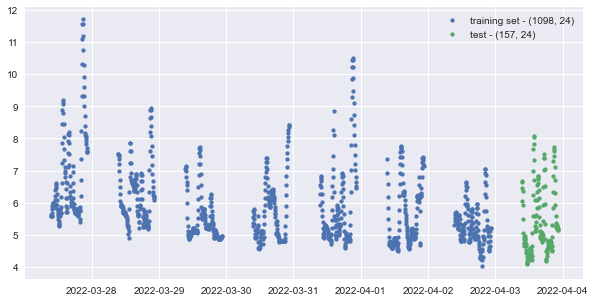

In [61]:
# plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(y=train['glucose'], x=train.index,
           label=f"training set - {train.shape}", s=15)
ax.scatter(y=test['glucose'], x=test.index,
           label=f"test - {test.shape}", s=15)
ax.legend()

In [ ]:
# specify forecast horizon
fh = ForecastingHorizon(test.asfreq("5T").index, is_relative=False)

In [119]:
# fit
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(train.asfreq('5T'))

# predict
y_pred = forecaster.predict(fh)

# # compute errors
err = timeseries_evaluation_metrics_func(test.asfreq('5T')['glucose'],
                                         y_pred['glucose'])
print(f'RMSE: err['rmse']')

1.0327065095903796


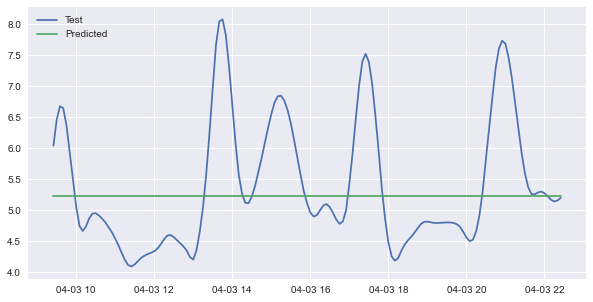

In [120]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(test['glucose'], label="Test")
ax.plot(y_pred['glucose'], label="Predicted")
ax.legend(loc='best')
fig.show()

# Naive mean:
- Forecast previous days using all values from previous day

In [16]:
# fit (157 is the size of each day)
forecaster = NaiveForecaster(strategy="mean", window_length=157, sp=157)
forecaster.fit(train.asfreq('5T'))

# predict
y_pred = forecaster.predict(fh, return_pred_int=True)

# # compute errors
err = timeseries_evaluation_metrics_func(test.asfreq('5T')['glucose'],
                                         y_pred['glucose'])
print(f"RMSE: {err['rmse']}")

NameError: name 'fh' is not defined

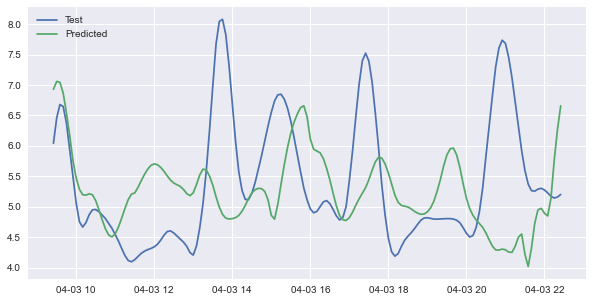

In [138]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(test['glucose'], label="Test")
ax.plot(y_pred['glucose'], label="Predicted")
ax.legend(loc='best')
fig.show()